# VTI sinusoid hill

In this notebook, we will consider the application of immersed boundaries to a set of pseudo-acoustic wave equations featuring VTI. This is based on the Fletcher et al. TTI formulation with all angles sent to zero.

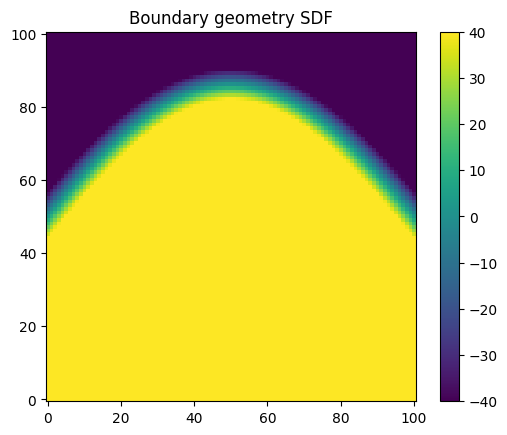

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=s_o, time_order=2)

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),
           dv.Eq(p.dx2+p.dy2, 0),
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0),
           dv.Eq(q, 0),
           dv.Eq(q.dx2+q.dy2, 0),
           dv.Eq(q.dx4 + 2*q.dx2dy2 + q.dy4, 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
derivs = (p.dx2, p.dy2, q.dx2, q.dy2)
subs = boundary.substitutions(derivs)

Generating stencils for Derivative(p(t, x, y), (x, 2))
Generating stencils for Derivative(p(t, x, y), (y, 2))
Generating stencils for Derivative(q(t, x, y), (x, 2))
Generating stencils for Derivative(q(t, x, y), (y, 2))


In [7]:
from examples.seismic import TimeAxis, RickerSource

v_py = 1.

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.6 seconds (600 ms)
dt = 0.5*10/v_py  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.

In [8]:
ep = dv.Function(name='epsilon', grid=grid)
de = dv.Function(name='delta', grid=grid)
de.data[:] = 0.1
ep.data[:] = 0.25
sig = 0.5  # Sigma parameter to control pseudoshear

v_pn = v_py*dv.sqrt(1+2*de)
v_px = v_py*dv.sqrt(1+2*ep)
v_sy = dv.sqrt(v_py**2*(ep-de)/sig)
# v_sy = 0

rhs_p = v_px**2*subs[p.dx2] + v_py**2*subs[q.dy2] + v_sy**2*subs[p.dy2] - v_sy**2*subs[q.dy2]
rhs_q = v_pn**2*subs[p.dx2] + v_py**2*subs[q.dy2] - v_sy**2*subs[p.dx2] + v_sy**2*subs[q.dx2]

eq_p = dv.Eq(p.forward,
             2*p - p.backward
             + dt**2*rhs_p)

eq_q = dv.Eq(q.forward,
             2*q - q.backward
             + dt**2*rhs_q)

In [9]:
src_p = src.inject(field=p.forward, expr=src*dt**2)
src_q = src.inject(field=q.forward, expr=src*dt**2)

In [10]:
op = dv.Operator([eq_p, eq_q] + src_p + src_q)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.07 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.06849800000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.8000000000000004e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

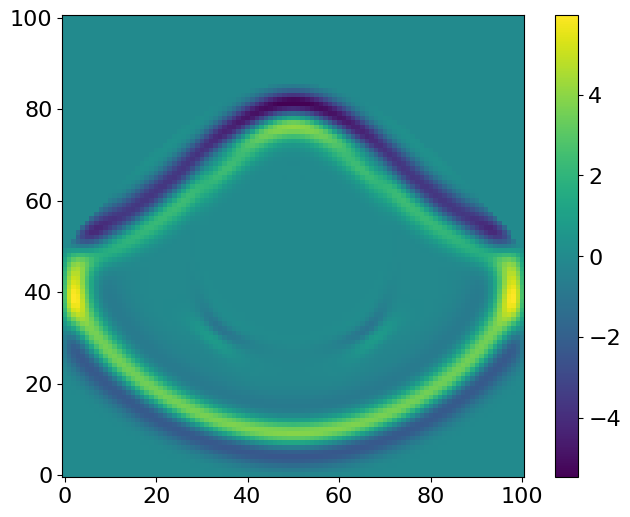

In [11]:
plt.imshow(p.data[1].T, origin='lower')
plt.colorbar()
plt.show()